In [3]:
!pip install torchsummary
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 3.4 MB/s eta 0:00:00


In [4]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb
import torchvision.transforms as transforms
import random
import albumentations as A
import timm
from albumentations.pytorch import ToTensorV2

In [350]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-67571472-fc8c-b8d3-36e7-f1b31b0bc46d)
GPU 1: Tesla T4 (UUID: GPU-b274f4fd-0ba8-1164-a21f-ee5a19754d1d)


In [351]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [352]:
num_classes = 3

# Number of epoch
epochs = 50

# Hyperparameters for training 
learning_rate = 0.0001
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/resunet_model.pth'
# pretrained_path = "/kaggle/input/abcdef/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [8]:
transform = A.Compose([
    A.Resize(height = 800, width = 1120),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(blur_limit=(2, 6), p=0.2),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value = 255.0),
    ToTensorV2()
    
])
test_transform = A.Compose([
    A.Resize(height = 800, width = 1120),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value = 255.0),
    ToTensorV2()
    
])

label_transform = A.Compose([
    A.Resize(height = 800, width = 1120),
    ToTensorV2()
])


In [354]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [5]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
    
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        data = np.array(data)
        label = np.array(label)
        # Normalize
        
        augmented = self.transform(image = data, mask = label)
        
        data= augmented["image"]
        label = augmented["mask"]
        data = data / 255
        label = label / 255
        
        
        
        label = torch.where(label>0.1, 1.0, 0.0)
        label[:, :, 2] = 0.0001
        label = torch.argmax(label, 2).type(torch.int64)
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [11]:
images_path = "/home/wallace/Code/HUST/UNET/data/train/train/"
masks_path =  "/home/wallace/Code/HUST/UNET/data/train_gt/train_gt/"

In [12]:
unet_dataset = UNetDataClass(images_path, masks_path, transform)

In [16]:
img, mask = unet_dataset[23]
print(f"[INFO] Dimesions of train images: {img.size()}")
print(f"[INFO] Dimesions of valid images: {mask.size()}")
print(f"[INFO] Data type of train images: {img.type()}")
print(f"[INFO] Data type of valid images: {mask.type()}") 

[INFO] Dimesions of train images: torch.Size([3, 800, 1120])
[INFO] Dimesions of valid images: torch.Size([800, 1120])
[INFO] Data type of train images: torch.FloatTensor
[INFO] Data type of valid images: torch.LongTensor


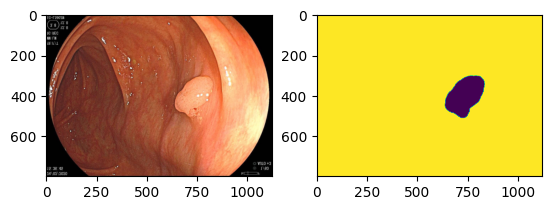

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [15]:
train_size = 0.85
valid_size = 0.15

In [361]:
train_set, valid_set = random_split(unet_dataset, 
                                    [int(train_size * len(unet_dataset)) , 
                                     int(valid_size * len(unet_dataset))])

In [362]:
len(train_set)

850

In [363]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [364]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class ResUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet50", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(2048, 1024)
        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        #x1 (B, 64, 128, 128) size/2
        #x2 (B, 256, 64, 64) size/4
        #x3 (B, 512, 32, 32) size/16
        #x4 (B, 1024, 16, 16) size/32
        #x5 (B, 2048, 8, 8) size/64
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x

In [365]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [366]:
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]


In [367]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [368]:
import torchmetrics
model = ResUnet(3).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

#metrics
dice_fn = torchmetrics.Dice(num_classes=3, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=3, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

In [369]:
from tqdm import tqdm
for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(train_dataloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x) #(B, C, H, W)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)
    
    save_model(model, optimizer, checkpoint_path)
    
    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 25:
        torch.save(model.state_dict(), "modelUNet_ep_{}.pth".format(ep))

  3%|▎         | 6/213 [00:10<05:54,  1.71s/it]


KeyboardInterrupt: 

# Create submission

In [370]:
transform = Compose([Resize((800, 1120), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

In [371]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [372]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=4, shuffle=True)

In [373]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

IndexError: index 4 is out of bounds for dimension 0 with size 4

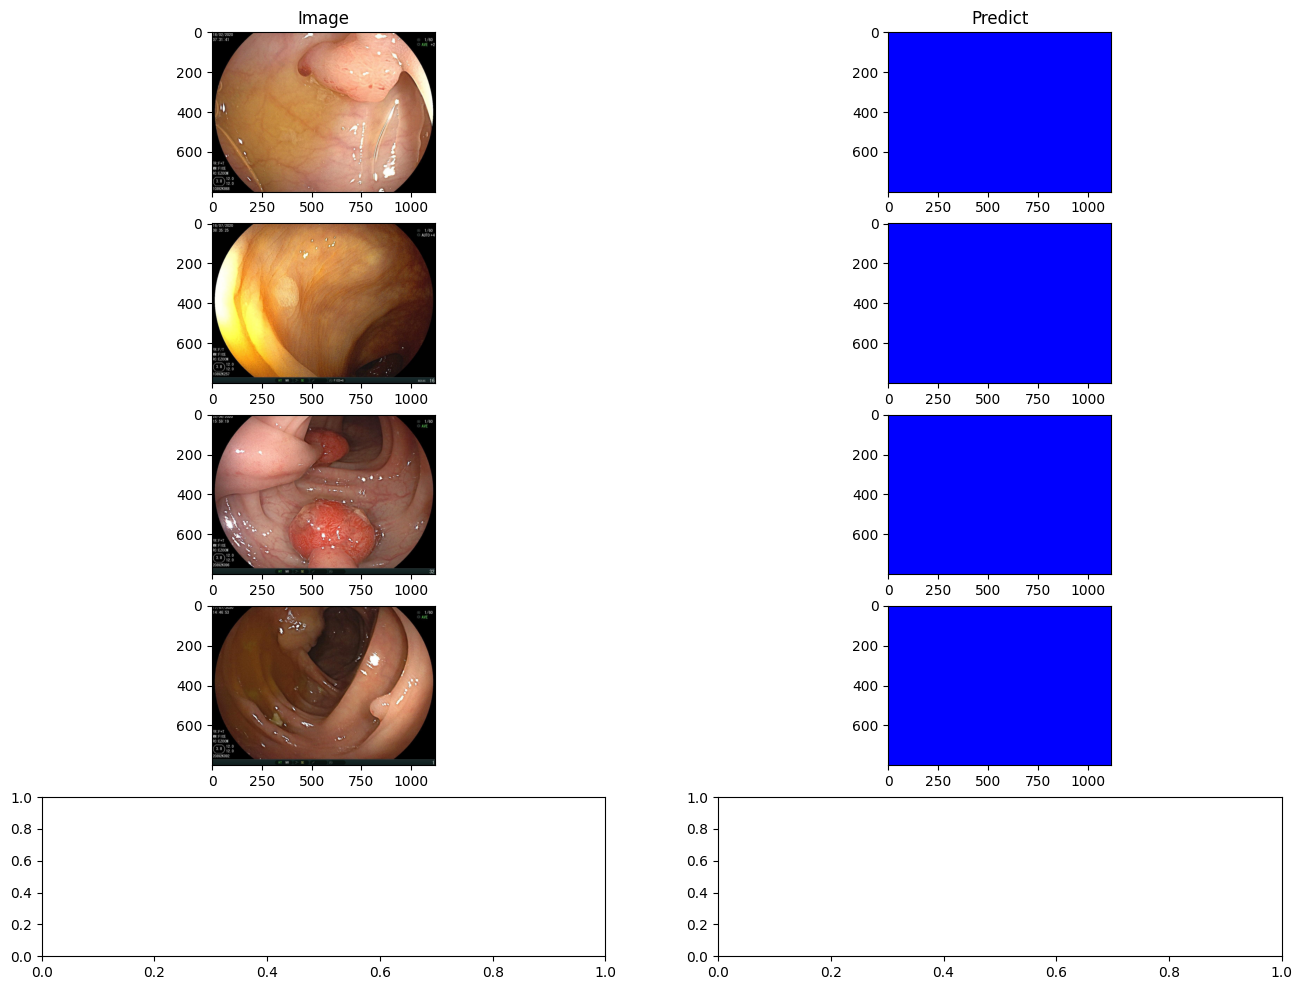

In [374]:
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');
model.to("cpu")
model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [375]:
model.to(device)
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    print(_)
    a = path
    b = img
    h = H
    w = W
    b = b.to(device)
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

0
1
2
3
4
5


KeyboardInterrupt: 

In [345]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

/kaggle/working/predicted_masks/7330398846f67b5df7cdf3f33c3ca4d5.png
/kaggle/working/predicted_masks/692195f853af7f8a4df1ec859759b7c8.png
/kaggle/working/predicted_masks/f8e26031fbb5e52c41545ba55aadaa77.png
/kaggle/working/predicted_masks/3425b976973f13dd311a65d2b46d0a60.png
/kaggle/working/predicted_masks/98da48d679d7c7c8d3d96fb2b87fbbcf.png
/kaggle/working/predicted_masks/63b8318ecf467d7ad048df39beb17636.png
/kaggle/working/predicted_masks/1002ec4a1fe748f3085f1ce88cbdf366.png
/kaggle/working/predicted_masks/d5060a633a8d5b2b2b55157b7781e2c7.png
/kaggle/working/predicted_masks/1c0e9082ea2c193ac8d551c149b60f29.png
/kaggle/working/predicted_masks/e56a6d9ba9d45c3dbc695325ded465ef.png
/kaggle/working/predicted_masks/395e56a6d9ba9d45c3dbc695325ded46.png
/kaggle/working/predicted_masks/a48847ae8395e56a6d9ba9d45c3dbc69.png
/kaggle/working/predicted_masks/c41545ba55aadaa77712a48e11d579d9.png
/kaggle/working/predicted_masks/39dda50f954ba59c7de13a35276a4764.png
/kaggle/working/predicted_masks/85

In [ ]:
print("="*10 + "ONE SAMPLE OF TARGET" + "="*10)
        print(f"[INFO] Size of target: {target.size()}")
        print(f"[INFO] Data type of target: {target.type()}")
        print(target)
        # create the labels one hot tensor
        target_one_hot = target.squeeze(1)
        # target_one_hot = one_hot(target, num_classes=input.shape[1],
                                #  device=input.device, dtype=input.dtype)
        print("="*10 + "ONE SAMPLE OF TARGET ONE-HOT" + "="*10)
        print(f"[INFO] Size of target one-hot: {target_one_hot.size()}")
        print(f"[INFO] Data type of target one hot: {target_one_hot.type()}")
        print(target_one_hot)

        # Binary Cross Entropy (BCE) loss
        print("="*10 + "ONE SAMPLE OF INPUT" + "="*10)
        print(f"[INFO] Size of input: {input.size()}")
        print(f"[INFO] Data type of input: {input.type()}")
        print(input)
        
        bce_loss = nn.BCEWithLogitsLoss()(input, target_one_hot)
        print(f"[INFO] BCE loss: {bce_loss}")